In [ ]:
%pip install networkx torch xgboost shap

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 738.3 kB/s eta 0:00:03
   ---------- ----------------------------

In [3]:
%pip install pandas numpy scikit-learn matplotlib jupyter

Note: you may need to restart the kernel to use updated packages.


Import python package

In [13]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap

Load two dataset (read CSV file)

In [14]:
maternal = pd.read_csv('maternal_health_risk.csv') 
pree = pd.read_csv('preeclampsia.csv') 

Feature Process


In [15]:
maternal['domain'] = 0
pree['domain'] = 1
maternal.rename(columns={'Age': 'age', 'SystolicBP': 'sysbp', 'DiastolicBP': 'diabp'}, inplace=True)
combined = pd.concat([maternal, pree], axis=0, ignore_index=True)

combined['target'] = np.where(combined['RiskLevel'] == 'high risk', 1, 0)
combined['target'] = combined['target'].fillna(combined['htn'].fillna(0))

features = ['age', 'sysbp', 'diabp', 'BS', 'BodyTemp', 'HeartRate', 'bmi', 'plgf:sflt', 'SEng']
X = combined[features].copy()
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Graph construction

In [16]:
G = nx.Graph()
for i in range(len(X_scaled)):
    G.add_node(i, features=X_scaled[i])

dist_matrix = euclidean_distances(X_scaled)
threshold = 0.3  # Tune this
for i in range(len(X_scaled)):
    for j in range(i + 1, len(X_scaled)):
        if dist_matrix[i][j] < threshold:
            G.add_edge(i, j, weight=1 - dist_matrix[i][j])

adj = nx.to_numpy_array(G)
adj_tensor = torch.tensor(adj, dtype=torch.float)
node_feats = torch.tensor(X_scaled, dtype=torch.float)
labels = torch.tensor(combined['target'].values, dtype=torch.float).unsqueeze(1)
domains = torch.tensor(combined['domain'].values, dtype=torch.float).unsqueeze(1)

5-fold CV

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_all, test_idx_all = next(cv.split(node_feats, labels.numpy()))

GCN with Reconstruction Layer

In [18]:
class UpdatedGCN(nn.Module):
    def __init__(self, in_features, hidden=64, embed_size=32, dropout_rate=0.5):
        super().__init__()
        self.gcn1 = nn.Linear(in_features, hidden)
        self.gcn2 = nn.Linear(hidden, embed_size)
        self.recon_layer = nn.Linear(embed_size, in_features)  
        self.domain_classifier = nn.Linear(embed_size, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, adj):
        adj_norm = adj + torch.eye(adj.size(0))
        degree = torch.sum(adj_norm, dim=1).clamp(min=1)
        adj_norm = adj_norm / degree.unsqueeze(1)
        emb = F.relu(self.gcn1(adj_norm @ X))
        emb = self.dropout(emb)
        emb = F.relu(self.gcn2(adj_norm @ emb))
        recon = self.recon_layer(emb)  
        return emb, recon

    def domain_forward(self, emb):
        return torch.sigmoid(self.domain_classifier(emb))

Hyperparameter Tuning for GCN

In [19]:
param_grid_gcn = {
    'hidden': [32, 64, 128],
    'embed_size': [16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7]
}
best_gcn = None
best_val_loss = float('inf')

for hidden in param_grid_gcn['hidden']:
    for embed_size in param_grid_gcn['embed_size']:
        for lr in param_grid_gcn['lr']:
            for dropout_rate in param_grid_gcn['dropout_rate']:
                gnn_model = UpdatedGCN(in_features=node_feats.shape[1], hidden=hidden, embed_size=embed_size, dropout_rate=dropout_rate)
                optimizer = Adam(gnn_model.parameters(), lr=lr)
                recon_criterion = nn.MSELoss()
                domain_criterion = nn.BCELoss()
                best_loss = float('inf')
                patience = 10
                counter = 0

                # Federated Simulation
                maternal_idx = combined[combined['domain'] == 0].index
                pree_idx = combined[combined['domain'] == 1].index
                clients = [maternal_idx, pree_idx]
                local_models = [UpdatedGCN(in_features=node_feats.shape[1], hidden=hidden, embed_size=embed_size, dropout_rate=dropout_rate) for _ in clients]

                for epoch in range(100):
                    total_loss = 0
                    for i, client_idx in enumerate(clients):
                        local_model = local_models[i]
                        local_model.train()
                        optimizer.zero_grad()
                        emb, recon = local_model(node_feats[client_idx], adj_tensor[client_idx][:, client_idx])
                        recon_loss = recon_criterion(recon, node_feats[client_idx])  # Self-supervised
                        domain_pred = local_model.domain_forward(emb)
                        domain_loss = domain_criterion(domain_pred, domains[client_idx])  # Domain adaptation
                        loss = recon_loss + 0.5 * domain_loss
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item()

                    with torch.no_grad():
                        for param, *local_params in zip(gnn_model.parameters(), *[m.parameters() for m in local_models]):
                            param.data = sum(p.data for p in local_params) / len(local_models)

                    gnn_model.eval()
                    with torch.no_grad():
                        val_emb, val_recon = gnn_model(node_feats[test_idx_all], adj_tensor[test_idx_all][:, test_idx_all])
                        val_loss = recon_criterion(val_recon, node_feats[test_idx_all])
                    if val_loss < best_loss:
                        best_loss = val_loss
                        counter = 0
                    else:
                        counter += 1
                        if counter >= patience:
                            break
                    if epoch % 10 == 0:
                        print(f"Hidden {hidden}, Embed {embed_size}, LR {lr}, Dropout {dropout_rate}, Epoch {epoch}: Val Loss {val_loss:.4f}")

                if best_loss < best_val_loss:
                    best_val_loss = best_loss
                    best_gcn = gnn_model

Hidden 32, Embed 16, LR 0.001, Dropout 0.3, Epoch 0: Val Loss 0.2409
Hidden 32, Embed 16, LR 0.001, Dropout 0.5, Epoch 0: Val Loss 0.3197
Hidden 32, Embed 16, LR 0.001, Dropout 0.7, Epoch 0: Val Loss 0.2759
Hidden 32, Embed 16, LR 0.01, Dropout 0.3, Epoch 0: Val Loss 0.2061
Hidden 32, Embed 16, LR 0.01, Dropout 0.5, Epoch 0: Val Loss 0.2986
Hidden 32, Embed 16, LR 0.01, Dropout 0.7, Epoch 0: Val Loss 0.2989
Hidden 32, Embed 16, LR 0.1, Dropout 0.3, Epoch 0: Val Loss 0.2470
Hidden 32, Embed 16, LR 0.1, Dropout 0.5, Epoch 0: Val Loss 0.2430
Hidden 32, Embed 16, LR 0.1, Dropout 0.7, Epoch 0: Val Loss 0.3793
Hidden 32, Embed 32, LR 0.001, Dropout 0.3, Epoch 0: Val Loss 0.2216
Hidden 32, Embed 32, LR 0.001, Dropout 0.5, Epoch 0: Val Loss 0.2439
Hidden 32, Embed 32, LR 0.001, Dropout 0.7, Epoch 0: Val Loss 0.2817
Hidden 32, Embed 32, LR 0.01, Dropout 0.3, Epoch 0: Val Loss 0.2343
Hidden 32, Embed 32, LR 0.01, Dropout 0.5, Epoch 0: Val Loss 0.2658
Hidden 32, Embed 32, LR 0.01, Dropout 0.7, Ep

Get best GCN embeddings
(Use embeddings for XGBoost)

In [21]:
best_gcn.eval()
with torch.no_grad():
    embeddings, _ = best_gcn(node_feats, adj_tensor)  
    embeddings = embeddings.numpy()

Tune XGBoost

In [22]:
param_grid_xgb = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
xgb = XGBClassifier(eval_metric='auc', scale_pos_weight=3)  
grid = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc')
grid.fit(X_scaled[train_idx_all], labels[train_idx_all].numpy().ravel())  


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'max_depth': [3, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


Final Hybrid Evaluation

In [23]:
xgb_best = grid.best_estimator_
test_preds = xgb_best.predict(X_scaled[test_idx_all])  
acc = accuracy_score(labels[test_idx_all].numpy(), test_preds)
auc = roc_auc_score(labels[test_idx_all].numpy(), xgb_best.predict_proba(X_scaled[test_idx_all])[:, 1])
print(f"Refined Hybrid Accuracy: {acc:.4f}, AUC: {auc:.4f}")
print(classification_report(labels[test_idx_all].numpy(), test_preds))

Refined Hybrid Accuracy: 0.9576, AUC: 0.9919
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       228
         1.0       0.82      1.00      0.90        55

    accuracy                           0.96       283
   macro avg       0.91      0.97      0.94       283
weighted avg       0.97      0.96      0.96       283



Visualizations

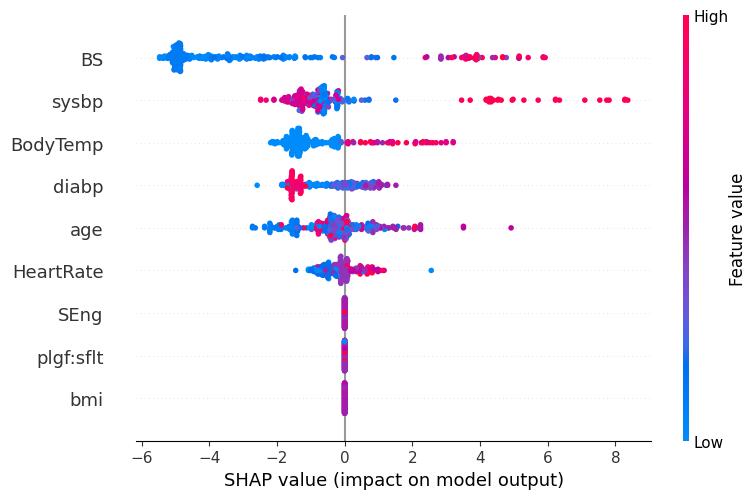

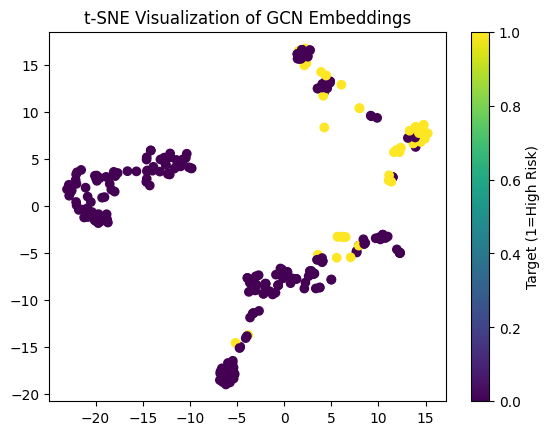

In [24]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_scaled[test_idx_all])  
shap.summary_plot(shap_values, X_scaled[test_idx_all], feature_names=features)

tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings[test_idx_all]) 
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=labels[test_idx_all].numpy(), cmap='viridis')
plt.colorbar(label='Target (1=High Risk)')
plt.title('t-SNE Visualization of GCN Embeddings')
plt.show()